In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
import inspect
from jupyterthemes import jtplot
jtplot.style()
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import random
from chainer.datasets import tuple_dataset
import time

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

class MLP(Chain):
    def __init__(self, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 100)
            self.l3 = L.Linear(None, 100)
            self.l4 = L.Linear(None, 80)
            self.l5 = L.Linear(None, 50)
            self.l6 = L.Linear(None, 20)
            self.l7 = L.Linear(None, n_out)
            
            
    def __call__(self, x):
        #層の結合結果に、活性化関数をかませる
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(h1))
        h3 = F.tanh(self.l3(h2))
        h4 = F.tanh(self.l4(h3))
        h5 = F.tanh(self.l5(h4))
        h6 = F.tanh(self.l6(h5))
        y = self.l7(h6)
        return y
    


In [8]:
import sys
sys.path.append("AjaxAndSocket/MLServer")
from bb2d import BinaryBoundary2D

bb2d = BinaryBoundary2D(640,480,MLP(2))

file = open("sample1.txt", mode='r')
txt = file.read()
file.close()

bb2d.setDataset(txt.strip())

start = time.time()
bb2d.train(0.02, 200)
elapsed = time.time() - start
print(elapsed, "[s]")

28.921804428100586 [s]


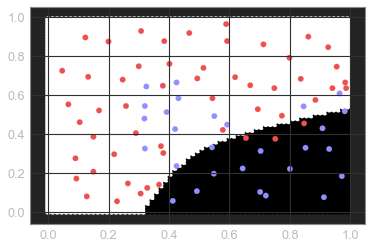

In [3]:
mesh, pred = bb2d.getBoundary(0.015)
cm = generate_cmap(['#FFFFFF', '#000000'])
plt.scatter(mesh[:,0], mesh[:,1], c=pred, cmap=cm)

cm = generate_cmap(['#EE5050', '#9090FF'])
plt.scatter(bb2d.trainPos[:,0], bb2d.trainPos[:,1], c=bb2d.trainT, cmap=cm)

## 別モデルの模索

In [4]:
class SimpleModel(Chain):
    def __init__(self, n_out):
        super(SimpleModel, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 100)
            self.l3 = L.Linear(None, n_out)
                        
    def __call__(self, x):
        #層の結合結果に、活性化関数をかませる
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [9]:
bb2d = BinaryBoundary2D(300,300,SimpleModel(2))

file = open("300300.txt", mode='r')
txt = file.read()

bb2d.setDataset(txt.strip())
start = time.time()
bb2d.train(0.02, 200)
elapsed = time.time() - start
print(elapsed, "[s]")

19.411556482315063 [s]


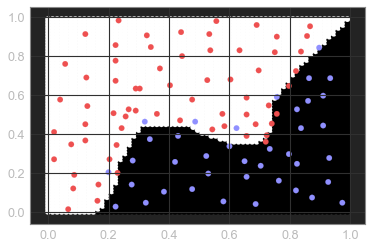

In [7]:
mesh, pred = bb2d.getBoundary(0.015)
cm = generate_cmap(['#FFFFFF', '#000000'])
plt.scatter(mesh[:,0], mesh[:,1], c=pred, cmap=cm)

cm = generate_cmap(['#EE5050', '#9090FF'])
plt.scatter(bb2d.trainPos[:,0], bb2d.trainPos[:,1], c=bb2d.trainT, cmap=cm)

In [ ]:
dataLen = pred.shape[0]

preMatrix = np.empty((3, dataLen))
preMatrix[0,:] = mesh.T[0,:]
preMatrix[1,:] = mesh.T[1,:]
preMatrix[2,:] = pred

result = "\n".join([",".join([str(np.round(m[0],3)), str(np.round(m[1],3)), str(int(m[2]))]) for m in preMatrix.T])


print(result)